# Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import seaborn as sns
import os
from PIL import Image
from IPython.display import display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Data Review

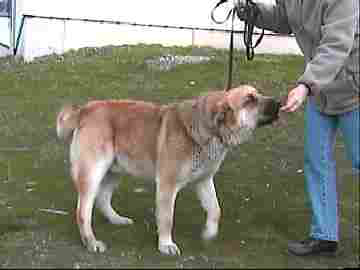

In [2]:
# Review single image
with Image.open('../Data/CATS_DOGS/train/DOG/1010.jpg') as im:
    display(im)

## Image statistics

In [3]:
# Top level path
path = '../Data/CATS_DOGS/'

# Create a list of image names
img_names = []
img_breakdown = []
for folder,subfolder,filenames in os.walk(path):
    for img in filenames:
        img_names.append(f'{folder}/{img}')
        img_breakdown.append([folder,img])

In [4]:
len(img_names)

24994

In [5]:
# Test images and create a list of image sizes
img_sizes = []
rejected = []

for img in img_names:
    try:
        with Image.open(img) as im:
            img_sizes.append(im.size)
    except:
        rejected.append(img)

/Users/adgb/opt/anaconda3/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:819: UserWarning: Truncated File Read
  warnings.warn(str(msg))


In [6]:
len(img_sizes)

24994

In [7]:
# Create dataframe for image analysis
df = pd.DataFrame(img_sizes)
df.rename(columns={0:'width', 1:'height'}, inplace=True)
df['image'] = img_names
df[['im_folder','file']] = img_breakdown
df['type'] = df['im_folder'].apply(lambda x: x.split('/')[-2])
df['species'] = df['im_folder'].apply(lambda x: x.split('/')[-1])

In [8]:
df.head()

,width,height,image,im_folder,file,type,species
0,365,500,../Data/CATS_DOGS/test/CAT/9733.jpg,../Data/CATS_DOGS/test/CAT,9733.jpg,test,CAT
1,484,500,../Data/CATS_DOGS/test/CAT/10321.jpg,../Data/CATS_DOGS/test/CAT,10321.jpg,test,CAT
2,448,500,../Data/CATS_DOGS/test/CAT/11981.jpg,../Data/CATS_DOGS/test/CAT,11981.jpg,test,CAT
3,500,483,../Data/CATS_DOGS/test/CAT/10447.jpg,../Data/CATS_DOGS/test/CAT,10447.jpg,test,CAT
4,500,375,../Data/CATS_DOGS/test/CAT/11759.jpg,../Data/CATS_DOGS/test/CAT,11759.jpg,test,CAT


In [9]:
df[['width','height']].describe()

,width,height
count,24994.000000,24994.000000
mean,404.493518,361.037129
std,108.941802,96.936811
min,42.000000,33.000000
25%,323.000000,302.000000
50%,448.000000,375.000000
75%,500.000000,421.000000
max,500.000000,500.000000


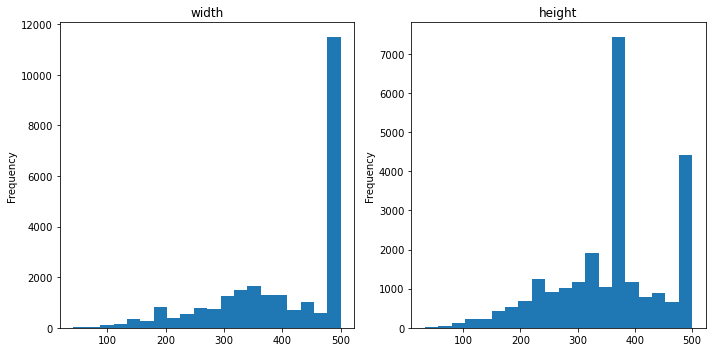

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
df['width'].plot(ax=ax[0], kind='hist', bins=20, title='width')
df['height'].plot(ax=ax[1], kind='hist', bins=20, title='height')
plt.tight_layout()

# Image preprocessing

## Transformations

Exploring the effect of transformation in an image

(500, 387)


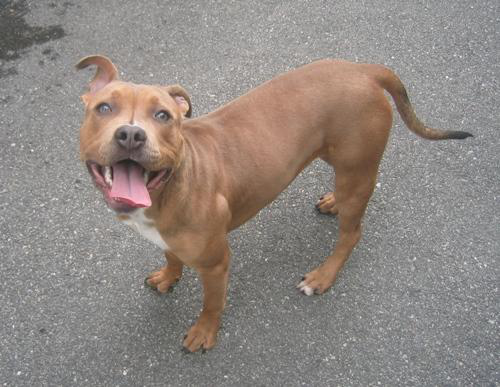

In [11]:
dog = Image.open('../Data/CATS_DOGS/train/DOG/14.jpg')
# Size is displayed as width,height
print(dog.size)
display(dog)

We can explore a single pixel and check the three channels (R,G,B) that it contains.

In [12]:
dog.getpixel((0,0))

(90, 95, 98)

Transformations can be amalgamated using `transforms.Compose()` 

### `transforms.ToTensor()`

The `transforms.ToTensor()` transformation converts a PIL Image (np.ndarray(HxWxC)) in the [0,255] range to a torch.FloatTensor of shape (C,H,W) in the range [0.0,1.0]

In [17]:
transform = transforms.Compose([
    transforms.ToTensor()
])

# Transform image to tensor
im = transform(dog)
print(im.shape)

torch.Size([3, 387, 500])


`plt.imshow()` expects a `np.ndarray` in shape (H,W,C) but the tensor is in shape (C,H,W). It needs to be converted to `np.ndarray` then transposed.

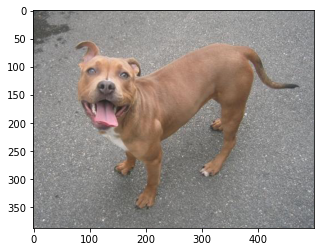

In [18]:
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

Reviewing the same pixel [0,0] we can see that it has been normalised by dividing by the max, 255 in this case $(\frac{x}{255})$ over the three channels

In [19]:
# Extract the first pixel of the three channels
im[:,0,0],im[:,0,0]*255

(tensor([0.3529, 0.3725, 0.3843]), tensor([90., 95., 98.]))

### `transforms.Resize()`

This will resize the image to the H and W provided. If a tuple of (h,w) is provided then the image will resize to that shape. If an integer is passed, the smaller edge of the image will be matched to this number and the image scaled accordingly.

torch.Size([3, 224, 289])


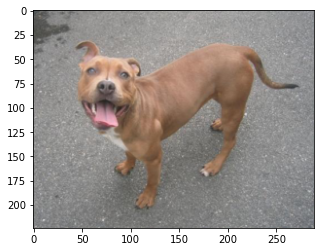

In [26]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor()
])

im = transform(dog)
print(im.shape)
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

Images can also be stretched.

(135, 102)


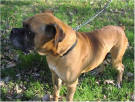

In [27]:
small_dog = Image.open('../Data/CATS_DOGS/train/DOG/11.jpg')
print(small_dog.size)
display(small_dog)

torch.Size([3, 224, 296])


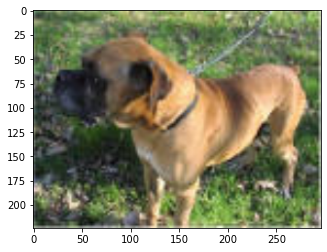

In [28]:
im = transform(small_dog)
print(im.shape)
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

### `transforms.CenterCrop()`

Crops an image from the centre to a given size. If the size is an integer instead of a (h,w) sequence, it crops a square from the centre.

torch.Size([3, 224, 224])


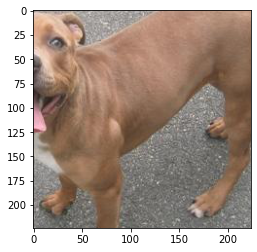

In [30]:
transform = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

im = transform(dog)
print(im.shape)
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

Normally, it is better to resize, then centre crop

torch.Size([3, 224, 224])


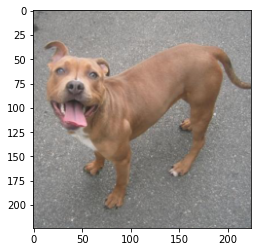

In [31]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

im = transform(dog)
print(im.shape)
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

**Other affine transformations**

An affine transformation is one that preserves points and straight lines such as rotation, reflection, and scaling.

### `transforms.RandomHorizontalFlip(p)`

Horizontal flip of a PIL image given probability $p$


torch.Size([3, 387, 500])


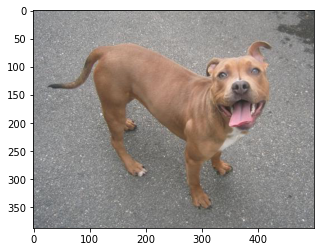

In [32]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(0.9),
    transforms.ToTensor()
])

im = transform(dog)
print(im.shape)
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

### `transforms.RandomRotation(d)`

Randomly rotates an image by an angle. If an integer instead of a sequence (min,max) degrees is given the range of degrees will be (-degrees,+degrees) 

torch.Size([3, 387, 500])


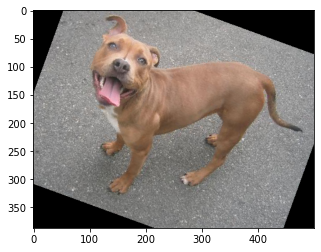

In [33]:
transform = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.ToTensor()
])

im = transform(dog)
print(im.shape)
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

torch.Size([3, 387, 500])


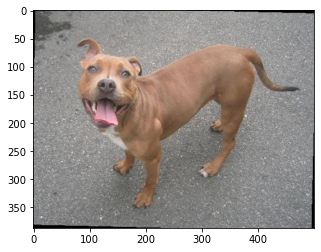

In [34]:
transform = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.ToTensor()
])

im = transform(dog)
print(im.shape)
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

torch.Size([3, 387, 500])


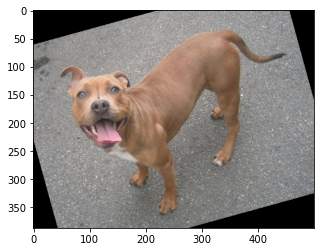

In [43]:
transform = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.ToTensor()
])

im = transform(dog)
print(im.shape)
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

### `transforms.Normalize()`

This transformation will take a tensor image and normalise it with a set of mean and std deviations. When using a pretrained network, we need to make sure that any image that we use has been normalised using the parameters that were used in the pretrained network.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 387, 500])


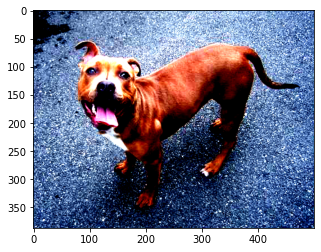

In [47]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

im = transform(dog)
print(im.shape)
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

If we check the top pixel for the three channels we will find they have been normalised using the parameters passed on the transformation $\frac{(x-\mu)}{\sigma}$

The original pixel values before normalisation were: `tensor([0.3529, 0.3725, 0.3843])`

In [42]:
im[:,0,0], (im[:,0,0]*torch.Tensor([0.229, 0.224, 0.225]))+torch.Tensor([0.485, 0.456, 0.406])

(tensor([-0.5767, -0.3725, -0.0964]), tensor([0.3529, 0.3725, 0.3843]))

Normalisations can be inversed by applying a normalisation transformation of the negative mean values divided by the std deviation and the inverse values of the standard deviations $\frac{-\mu}{\sigma},\frac{1}{\sigma}$

torch.Size([3, 387, 500])


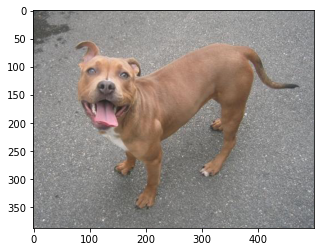

In [48]:
transform = transforms.Compose([
    transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                         std=[1/0.229, 1/0.224, 1/0.225])
])

im_inv = transform(im)
print(im_inv.shape)
plt.imshow(np.transpose(im_inv.numpy(),(1,2,0)))

### `transforms.Grayscale()`

This transformation will change RGB images into grayscale images.

torch.Size([1, 387, 500])


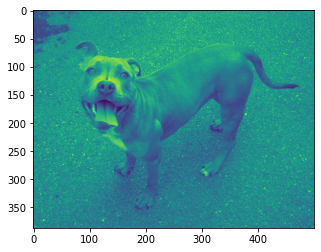

In [50]:
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor()
])

im = transform(dog)
print(im.shape)
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

### `transforms.GaussianBlur()`

This tranformation blurs the image with a randomly chosen Gaussian blur. It takes as parameter the `kernel_size` 

torch.Size([3, 387, 500])


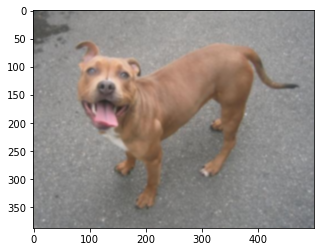

In [64]:
transform = transforms.Compose([
    transforms.GaussianBlur(11),
    transforms.ToTensor()
])

im = transform(dog)
print(im.shape)
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

### Functional Transformations

These provide fine-grainedcontrol of the transformation to be applied in the image.

#### `transforms.functional.adjust_brightness()`

Transformation that adjusts the brigness of an image. 

torch.Size([3, 387, 500])


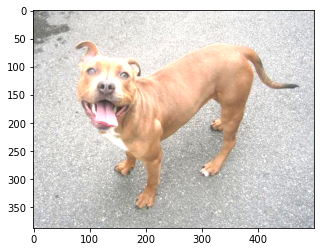

In [73]:
transform = transforms.ToTensor()

im = transforms.functional.adjust_brightness(dog,1.5)
im = transform(im)

print(im.shape)
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

#### `transforms.functional.adjust_contrast()`

Transformation that adjusts the contrast of an image. 

torch.Size([3, 387, 500])


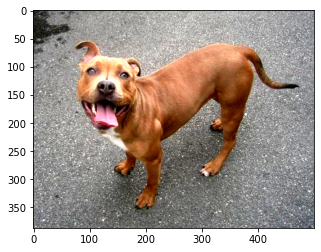

In [76]:
transform = transforms.ToTensor()

im = transforms.functional.adjust_contrast(dog,2)
im = transform(im)

print(im.shape)
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

#### `transforms.functional.adjust_hue()`

Transformation that adjusts the hue of an image. 

torch.Size([3, 387, 500])


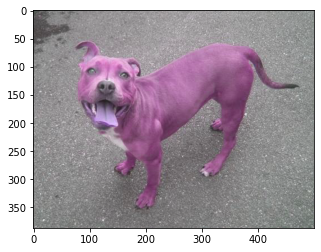

In [81]:
transform = transforms.ToTensor()

im = transforms.functional.adjust_hue(dog,-0.2)
im = transform(im)

print(im.shape)
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

#### `transforms.functional.adjust_saturation()`

Transformation that adjusts the saturation of an image. 

torch.Size([3, 387, 500])


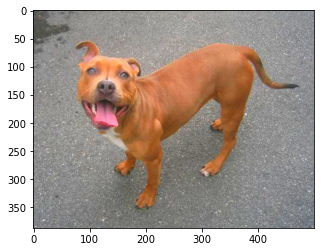

In [85]:
transform = transforms.ToTensor()

im = transforms.functional.adjust_saturation(dog,2)
im = transform(im)

print(im.shape)
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

#### `transforms.functional.adjust_sharpness()`

Transformation that adjusts the sharpness of an image. 

torch.Size([3, 387, 500])


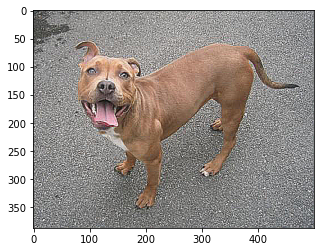

In [91]:
transform = transforms.ToTensor()

im = transforms.functional.adjust_sharpness(dog,10)
im = transform(im)

print(im.shape)
plt.imshow(np.transpose(im.numpy(),(1,2,0)))